# SVM regressor on the California housing dataset

Let's load the dataset using Scikit-Learn's ``fetch_california_housing()`` function:

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [47]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

Let's look at the description of the dataset

In [91]:
print(housing.DESCR)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




In [105]:
print(np.count_nonzero(X))
print(X.size)

165120
165120


The dataset therefore is dense.

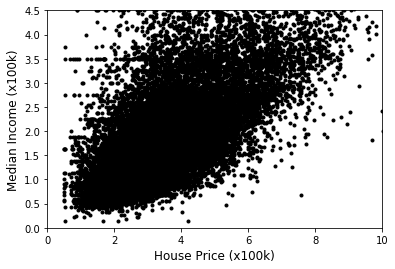

In [124]:
plt.plot(X[:,0], y, "k.")
plt.xlabel("House Price (x100k)", fontsize=12)
plt.ylabel("Median Income (x100k)", rotation=90, fontsize=12)
plt.axis([0, 10, 0, 4.5])
plt.show()

Split it into a training set and a test set:

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scale the data

syntax: ``scaler.fit_transform(X, y=None, **fit_params)``, fits transformer to X and y with optional parameters ``fit_params`` and returns a transformed version of X.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Let's train a simple ``LinearSVR`` first:

In [14]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR()#random_state=42)
lin_svr.fit(X_train_scaled, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

We check how well it works on the training set

In [134]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
print(lin_svr.coef_)
mse = mean_squared_error(y_train, y_pred)
rmse=np.sqrt(mse)
rmse

[ 0.9220049   0.08771634 -0.37944695  0.42328756  0.00955327 -0.68555979
 -0.74797643 -0.74408073]


0.9768016949821263

In [40]:
print(lin_svr.coef_)

[ 0.9220049   0.08771634 -0.37944695  0.42328756  0.00955327 -0.68555979
 -0.74797643 -0.74408073]


Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for C and gamma:

In [151]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

Note the syntax: ``SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)``. The free parameters in the model are the penalty C and the tolerance epsilon. ``RandomizedSearchCV`` implements randomized search on hyper parameters.


In [158]:
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.6s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   6.4s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   6.6s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   5.0s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   5.1s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   6.1s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   5.0s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   5.7s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.6min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1f747978>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1f747438>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [159]:
print(rnd_search_cv.best_estimator_)
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
rmse=np.sqrt(mse)
print(rmse)

SVR(C=4.745401188473625, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.07969454818643928, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)
0.5727524770785359


This cost function for ``RandomizedSearchCV`` is much smaller than the naive ``LinearSVR``